In [1]:
import pandas as pd
import os
import ast
import numpy as np
import math
import random
from copy import deepcopy
%matplotlib inline
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# The scripts stored the outputs as dictionaries.
all_results = []
for f in os.listdir('.'):
    if '.data' in f:
        with open(f, 'r') as g:
            all_results.append(ast.literal_eval(g.read()))

In [3]:
# Standardize units of MIC
def standardize_to_uM(concentration, unit, sequence):
    concentration = concentration.replace(' ', '')
    try:
        concentration = float(concentration)
    except:
        return None
    if unit == 'uM' or unit == u'\xb5M' or unit == u'uM)':
        return concentration
    elif unit == 'ug/ml' or unit == u'\xb5g/ml' or unit == u'ug/ml)':
        try:
            molWt = ProteinAnalysis(sequence).molecular_weight()
        except ValueError:
            return None
        return concentration * 1000/molWt
    elif unit == 'nmol/g' or unit == 'pmol/mg':
        #1g, at density of 1g/mL, is 1mL, so nmol/g is nmol/mL = umol/L = uM yay!
        return concentration
    else:
        # print 'Unit not recognized: ' + unit
        return None

In [4]:
# Enter an element of a result dictionary into df-ready row
def convert_result_to_rows(sequence, result):
    rows = []
    if 'bacteria' not in result:
        return rows
    for bacterium, strain in result['bacteria']:
        
        rows.append({
            'bacterium': bacterium,
            'strain': strain,
            'sequence': sequence.upper(),
            'url_source': result['url_sources'][0],
            'value': standardize_to_uM(
                result['bacteria'][(bacterium, strain)]['value'],
                result['bacteria'][(bacterium, strain)]['unit'],
                sequence
            ),
            'modifications': result['modifications'] if 'modifications' in result else [],
            'unit': 'uM'
        })
        if rows[-1]['value']:
            rows[-1]['value'] = np.log10(rows[-1]['value'])
    return rows

In [5]:
# Load all the rows into an array
rows = []
for result_set in all_results:
    for sequence in result_set:
        for row in convert_result_to_rows(sequence, result_set[sequence]):
            rows.append(row)

In [6]:
# Construct the df
df = pd.DataFrame(rows)

In [7]:
print("Dataframe length before removing bad chars:", len(df))
# Remove sequences with amino acids that aren't well-defined
def strip_sequences_with_char(df, bad_char):
    return df[~df.sequence.str.contains(bad_char)]

for bad_char in ['U', 'X', 'Z']:
    df = strip_sequences_with_char(df, bad_char)
print("Dataframe length after removing bad chars:", len(df))

('Dataframe length before removing bad chars:', 62494)
('Dataframe length after removing bad chars:', 57697)


In [8]:
# We'll want to strip off any sequences with modifications that could be hard to replicate
# Their effects are too complex for the model
def is_modified(modifications_list):
    return len(modifications_list) > 0

df['is_modified'] = df.modifications.apply(is_modified)

In [9]:
# However, C-Terminal Amidation is common enough that we make an exception
def has_non_cterminal_modification(modifications_list):
    return any(['C-Term' not in modification for modification in modifications_list])

df['has_non_cterminal_modification'] = df.modifications.apply(has_non_cterminal_modification)

df['has_cterminal_modification'] = df.is_modified & ~df.has_non_cterminal_modification

In [10]:
# Clean sequences by removing newlines and one improper sequence
df.sequence = df.sequence.str.strip()
df = df.loc[df.sequence != '/']

In [11]:
# Exclude sequences with modifications
# Exclude rows from YADAMP and CAMP for having no modification data
#     Unless that sequence is in another DB

df = df.loc[df.has_non_cterminal_modification == False]

no_modification_data_sources = ['camp3', 'yadamp']

def datasource_has_modifications(cell):
    # Everything except CAMP and YADAMP has modification data
    return not any([s in cell for s in no_modification_data_sources])

df['_datasource_has_modifications'] = df['url_source'].apply(datasource_has_modifications)

sequences_containing_modifications = set(df.loc[df._datasource_has_modifications == True, 'sequence'])
def sequence_has_modification_data(cell):
    # If the sequence is labeled modifictationless in another database it's OK
    return cell in sequences_containing_modifications

df['_sequence_has_modifications'] = df['sequence'].apply(sequence_has_modification_data)

df['modification_verified'] = df['_sequence_has_modifications'] | df['_datasource_has_modifications']

df = df.loc[df.modification_verified == True]

In [317]:
CHARACTER_DICT = set([character for sequence in df.sequence for character in sequence])
MAX_SEQUENCE_LENGTH = int(df.sequence.str.len().describe(percentiles=[0.95])['95%'])

# Each amino acid its own group
character_to_index = {
    (character): i
    for i, character in enumerate(CHARACTER_DICT)
}

# Group them together heavily
"""character_to_index = {
    ('R', 'K', 'H'): 0,
    ('D', 'E'): 1,
    ('S', 'T', 'N', 'Q', 'C'): 2,
    ('A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'P', 'G'): 3,
}

# Group them together more sparingly
character_to_index = {
    ('R'): 0,
    ('H'): 1,
    ('K'): 2,
    ('D', 'E'): 3,
    ('S', 'T', 'N', 'Q', 'C'): 4,
    ('G', 'P'): 5,
    ('A', 'V', 'I', 'L', 'M'): 6,
    ('F', 'Y', 'W'): 7,
}"""

index2character = {
    value: key
    for key, value in character_to_index.items()
}

def sequence_to_vector(sequence, cterminal_amidation):
# It looks like this truncates any sequence after max_sequence_length (which is length of 95th percentile longest peptide)
# I just add cterminal amidation as the amino acid after the last real amino acid (if the amino acid gets truncated
# then the cterminal amidation also gets cut off)
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
    if len(sequence)<MAX_SEQUENCE_LENGTH:
        default[len(sequence)][-1]=cterminal_amidation
    return default

def old_sequence_to_vector(sequence, cterminal_amidation):
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])
    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][character_to_index[character]] = 1
        default[i][-1] = cterminal_amidation
    return default

def find_character(character2index, character):
    for key in character2index:
        if character in key:
            return character2index[key]
    return -2

def row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_modification']
    return sequence_to_vector(sequence,cterminal_amidation)

def old_row_to_vector(row, shuffle_sequence=False):
    sequence = list(row['sequence'])
    if shuffle_sequence:
        random.shuffle(sequence)
    cterminal_amidation = row['has_cterminal_modification']
    default = np.zeros([MAX_SEQUENCE_LENGTH, len(character_to_index) + 1])

    for i, character in enumerate(sequence[:MAX_SEQUENCE_LENGTH]):
        default[i][find_character(character_to_index, character)] = 1
        default[i][-1] = cterminal_amidation

    return default

def vector_to_amp(vector):
    sequence = ''
    has_cterm = False
    for v in vector:
        nonzeros = np.argwhere(v[:len(character_to_index)])
        if len(nonzeros) > 1:
            print("?????")
        elif len(nonzeros) == 0:
            sequence += '_'
        else:
            sequence += index2character[np.argwhere(v)[0][0]]  # First one
        if v[-1]>0:
            has_cterm=True
    return {
        'sequence': sequence,
        'cterminal_amidation': has_cterm
    }

def bacterium_to_sample_weight(bacterium, intended_bacterium='E. coli'):
    if intended_bacterium in bacterium:
        return 1
    else:
        return 0.5

In [318]:
def containing_bacterium(bacterium, df):
    return df.loc[df.bacterium.str.contains(bacterium)]

def average_over_databases(bacterium_df):
    return bacterium_df.groupby('sequence')['value'].mean().dropna()

staph = containing_bacterium('S. aureus', df)
staph = average_over_databases(staph)

ecoli = df.loc[df.bacterium.str.contains('E. coli')].groupby('sequence')['value'].mean().dropna()
pseudomonas = df.loc[df.bacterium.str.contains('P. aeruginosa')].groupby('sequence')['value'].mean().dropna()
streptococcus = df.loc[df.bacterium.str.contains('S. mutans')].groupby('sequence')['value'].mean().dropna()
bacillus = df.loc[df.bacterium.str.contains('B. subtilis')].groupby('sequence')['value'].mean().dropna()

In [319]:
# Show the correlation between bacteria
# Note that Gram-Positivity seems to have a strong effect on correlation
# E. coli and pseudomonas are highly correlated
# While neither is correlated with streptococcus, staph or bacillus
# Meanwhile, staph and streptococcus are strongly correlated as expected
# As are bacillus and streptococcus
# The lack of correlation between bacillus and staph is a mystery to me
many_bacteria = pd.concat([ecoli, pseudomonas, streptococcus, staph, bacillus], axis=1).reset_index()
many_bacteria.columns = ['index', 'ecoli', 'pseudomonas', 'streptococcus', 'staph', 'bacillus']
many_bacteria.corr()

,ecoli,pseudomonas,streptococcus,staph,bacillus
ecoli,1.00,0.78,0.71,0.67,0.69
pseudomonas,0.78,1.00,0.52,0.65,0.60
streptococcus,0.71,0.52,1.00,0.83,0.82
staph,0.67,0.65,0.83,1.00,0.67
bacillus,0.69,0.60,0.82,0.67,1.00


In [320]:
# Since ecoli data and pseudomonas data are highly correlated, we will use some pseudomonas data in the model
# (With a lower sample weight)
ecoli_pseudomonas = many_bacteria.dropna(subset=('ecoli', 'pseudomonas'))
x = np.array(ecoli_pseudomonas['pseudomonas']).reshape(-1, 1)
y = np.array(ecoli_pseudomonas['ecoli']).reshape(-1, 1)
pseudomonas_to_ecoli_model = LinearRegression().fit(x, y)

In [321]:
def get_bacterium_df(bacterium, df):
    bdf = df.loc[(df.bacterium.str.contains(bacterium))].groupby(['sequence', 'bacterium'])
    return bdf.mean().reset_index().dropna()

In [322]:
def strip_bad_amino_acids(df, bad_amino_acids=('U', 'X', 'Z')):
    for b in bad_amino_acids:
        df = df.loc[~df.sequence.str.contains(b)]
    return df

In [323]:
ecoli_df = get_bacterium_df('E. coli', df)
ecoli_df = strip_bad_amino_acids(ecoli_df)

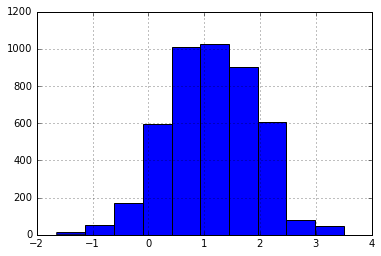

In [324]:
# MIC on E. coli is normally distributed-ish
ecoli_df.value.hist()

In [325]:
# Generate the input vectors for our model
# Each vector is two dimensional
# The first dimension represents the number of characters in the sequence (46 characters)
# Each character is a vector of length equal to the number of groupings of amino acids
# This grouping can be 1-1 (each amino acid gets its own group), or coarser
SHUFFLE_SEQUENCE = False
cterminal_amidation = np.array(ecoli_df.has_cterminal_modification)

vectors = []
for row in ecoli_df.iterrows():
    vectors.append(row_to_vector(row[1], shuffle_sequence=SHUFFLE_SEQUENCE))

vectors = np.array(vectors)

labels = np.array(ecoli_df.value)
sample_weights = np.full(len(labels), 1)

In [326]:
def generate_random_sequence(alphabet, length_of_sequence_min=25, length_of_sequence_max=40):
        sequence = ''
        for _ in range(random.choice(range(length_of_sequence_min, length_of_sequence_max))):
            sequence += random.choice(list(alphabet))
        has_cterminal_modification = random.choice([0, 1])

        return {
            'sequence': sequence,
            'has_cterminal_modification': has_cterminal_modification
        }

def add_random_negative_examples(vectors, labels, sample_weights, ratio, max_mic = None):
    if not max_mic:
        max_mic = max(labels)
    # We will add randomly chosen sequences as negative examples
    # We will double the length of our training set

    len_vectors = ratio * len(vectors)
    negative_rows = []
    for i in range(len_vectors):
        negative_rows.append(row_to_vector(generate_random_sequence(list(CHARACTER_DICT))))
    negative_vectors = np.array(negative_rows)
    vectors = np.concatenate((vectors, negative_vectors))
    negative_labels = np.full(len_vectors, max_mic)
    labels = np.concatenate((labels, negative_labels))
    # Weight all samples equally
    sample_weights = np.concatenate((sample_weights, np.full(len_vectors, 1)))
    return vectors, labels, sample_weights

In [327]:
MAX_MIC = 3.5
vectors, labels, sample_weights = add_random_negative_examples(vectors, labels, sample_weights, ratio=1, max_mic=MAX_MIC)

In [328]:
print("Vector shape after adding negative examples")
print(vectors.shape)

Vector shape after adding negative examples
(9016, 46, 21)


In [329]:
# Create simulated ecoli data from pseudomonas data
bacteria_name = 'P. aeruginosa'
pa_df = df.loc[(df.bacterium.str.contains(bacteria_name))].groupby(['sequence', 'bacterium'])
pa_df = pa_df.mean().reset_index().dropna()

pa_cterminal_amidation = np.array(pa_df.has_cterminal_modification)

pa_vectors = []
for row in pa_df.iterrows():
    pa_vectors.append(row_to_vector(row[1], shuffle_sequence=SHUFFLE_SEQUENCE))

pa_vectors = np.array(pa_vectors)

pa_labels = np.array(pa_df.value.apply(pseudomonas_to_ecoli_model.predict))  # Interpolate using the linear model
pa_sample_weights = np.array([0.5] * len(pa_labels))

In [330]:
average = np.mean(labels)
squared_errors = sum([(label - average) ** 2 for label in labels])
baseline_error = squared_errors/len(labels)
print("Baseline error:")
print(baseline_error)
measured_labels = [l for l in labels if l < MAX_MIC]
average = np.mean(measured_labels)
squared_errors = sum([(label - average) ** 2 for label in measured_labels])
baseline_error = squared_errors/len(measured_labels)
print("Baseline error on measured examples only")
print(baseline_error)

Baseline error:
1.6979921723869722
Baseline error on measured examples only
0.5995982451676932


In [331]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
linear_estimator = LinearRegression()
#cross_val_score(linear_estimator, vectors.reshape(vectors.shape[0], -1)[:10], labels[:10])
i = 200
#cross_val_score(linear_estimator, np.full(i, 1).reshape(-1, 1), random_labels, scoring='neg_mean_squared_error')
#linear_estimator.fit(vectors.reshape(vectors.shape[0], -1)[:95], labels[:95])
linear_estimator.fit(np.full(shape=(len(labels)), fill_value=1).reshape(-1, 1), labels)
#cross_val_score(linear_estimator, vectors.reshape(vectors.shape[0], -1), labels, scoring='neg_mean_squared_error')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [332]:
import keras
from keras.layers import Dense, Dropout, LSTM, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [333]:
def generate_train_test_splits(
        vectors, labels,
        extra_training_vectors=[], extra_training_labels=[], extra_sample_weights=[],
        cutoff=0.85
):
    cutoff = int(cutoff * len(labels))
    idx = range(len(vectors))
    random.shuffle(idx)
    reordered_vectors = vectors[idx]
    reordered_labels = labels[idx]
    reordered_sample_weights = sample_weights[idx]
    if len(extra_training_vectors) > 0:
        train_x = np.concatenate((reordered_vectors[:cutoff], extra_training_vectors))
        train_y = np.concatenate((reordered_labels[:cutoff], extra_training_labels))
        train_sample_weights = np.concatenate((reordered_sample_weights[:cutoff], pa_sample_weights))
    else:
        train_x = reordered_vectors[:cutoff]
        train_y = reordered_labels[:cutoff]
        train_sample_weights = reordered_sample_weights[:cutoff]
    test_x = reordered_vectors[cutoff:]
    test_y = reordered_labels[cutoff:]
    return train_x, train_y, test_x, test_y, train_sample_weights

In [106]:
# Vanilla LSTM
def baseline_model():
    model = keras.models.Sequential()
    model.add(LSTM(
        128,
        input_shape=(MAX_SEQUENCE_LENGTH, len(character_to_index) + 1),
    ))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='normal'))
    model.add(Dense(20, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [107]:
# Doesn't work as well as conv model
model = baseline_model()
train_x, train_y, test_x, test_y, _ = generate_train_test_splits(vectors, labels, pa_vectors, pa_labels, pa_sample_weights)
model.fit(train_x, train_y, sample_weight=[], batch_size=40, epochs=100)

Epoch 1/100
17820/17820 [==============================] - 61s 3ms/step - loss: 1.7907
Epoch 2/100
 8080/17820 [============>.................] - ETA: 31s - loss: 1.6299

KeyboardInterrupt: 

In [71]:
print("LSTM test error, MSE of log MIC")
print(model.evaluate(test_x, test_y))

LSTM test error, MSE of log MIC
1353/1353 [==============================] - 0s 263us/step
0.2881708491403618


In [66]:
np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, model.predict(test_x)) if actual < MAX_MIC
    ]
)

0.48717642

In [334]:
# Convolutional NN
def conv_model():
    model = keras.models.Sequential()
    model.add(Conv1D(
        64,
        kernel_size = 5,
        strides = 1,
        activation = 'relu',
        input_shape = (MAX_SEQUENCE_LENGTH, len(character_to_index) + 1)
    ))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    #model.add(Dropout(0.5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [338]:
convmodel = conv_model()
train_x, train_y, test_x, test_y, _ = generate_train_test_splits(vectors, labels, pa_vectors, pa_labels, pa_sample_weights)
convmodel.fit(train_x, train_y, batch_size=40, epochs=100)

Epoch 1/100
10156/10156 [==============================] - 4s 384us/step - loss: 0.8658
Epoch 2/100
10156/10156 [==============================] - 4s 351us/step - loss: 0.5011
Epoch 3/100
10156/10156 [==============================] - 3s 340us/step - loss: 0.4056
Epoch 4/100
10156/10156 [==============================] - 3s 280us/step - loss: 0.3405
Epoch 5/100
10156/10156 [==============================] - 3s 272us/step - loss: 0.2930
Epoch 6/100
10156/10156 [==============================] - 3s 323us/step - loss: 0.2573
Epoch 7/100
10156/10156 [==============================] - 3s 267us/step - loss: 0.2348
Epoch 8/100
10156/10156 [==============================] - 3s 271us/step - loss: 0.2216
Epoch 9/100
10156/10156 [==============================] - 3s 268us/step - loss: 0.2017
Epoch 10/100
10156/10156 [==============================] - 3s 265us/step - loss: 0.1848
Epoch 11/100
10156/10156 [==============================] - 3s 265us/step - loss: 0.1701
Epoch 12/100
10156/10156 [====

In [339]:
print("CNN test error, MSE of log MIC")
print(convmodel.evaluate(test_x, test_y))

CNN test error, MSE of log MIC
1353/1353 [==============================] - 0s 306us/step
0.18398004318728592


In [110]:
# THIS IS THE OLD ONE
print("CNN test error, MSE of log MIC")
print(convmodel.evaluate(test_x, test_y))

CNN test error, MSE of log MIC
2705/2705 [==============================] - 1s 193us/step
0.10254753295077414


In [340]:
print("CNN test error on measured examples only")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only
0.27704197


In [111]:
# THIS IS THE OLD ONE
print("CNN test error on measured examples only")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only
0.38956055


In [303]:
print("CNN test error, MSE of log MIC (RANDOM SHUFFLED SEQUENCE)")
print(convmodel.evaluate(test_x, test_y))

CNN test error, MSE of log MIC (RANDOM SHUFFLED SEQUENCE)
1353/1353 [==============================] - 0s 106us/step
0.17386886583199257


In [304]:
print("CNN test error on measured examples only (RANDOM SHUFFLED SEQUENCE)")
print(np.mean(
    [(actual - predicted) ** 2 
     for actual, predicted in zip(test_y, convmodel.predict(test_x)) if actual < MAX_MIC
    ]
))

CNN test error on measured examples only (RANDOM SHUFFLED SEQUENCE)
0.29721802


In [75]:
scales={'Eisenberg':{'A':  0.25, 'R': -1.80, 'N': -0.64,'D': -0.72, 'C':  0.04, 'Q': -0.69,'E': -0.62, 'G':  0.16, 'H': -0.40,'I':  0.73, 'L':  0.53, 'K': -1.10,'M':  0.26, 'F':  0.61, 'P': -0.07,'S': -0.26, 'T': -0.18, 'W':  0.37,'Y':  0.02, 'V':  0.54},
'Normalized_consensus':{'A':0.62,'C':0.29,'D':-0.9,'E':-0.74,'F':1.19,'G':0.48,'H':-0.4,'I':1.38,'K':-1.5,'L':1.06,'M':0.64,'N':-0.78,'P':0.12,'Q':-0.85,'R':-2.53,'S':-0.18,'T':-.05,'V':1.08,'W':0.81,'Y':0.26}}

def hydrophobic_moment(sequence,scale='Normalized_consensus',angle=0,is_in_degrees=True,normalize=True):
    # Angle should be 100 for alpha helix, 180 for beta sheet
    hscale=scales[scale]
    sin_sum = 0
    cos_sum = 0
    moment=0
    for i in range(len(sequence)):
        hp=hscale[sequence[i]]
        angle_in_radians=i*angle
        if is_in_degrees:
            angle_in_radians = (i*angle)*math.pi/180.0
        sin_sum += hp*math.sin(angle_in_radians)
        cos_sum += hp*math.cos(angle_in_radians)
    moment = math.sqrt(sin_sum**2+cos_sum**2)
    if normalize:
        moment = moment/len(sequence)
    return moment

In [114]:
ecoli_amps_sequence = ecoli_df['sequence']
amp_hydrophobic_moments = ecoli_amps_sequence.apply(hydrophobic_moment)

shuffled_ecoli_amps = ecoli_amps_sequence.apply(lambda x: ''.join(random.sample(x, len(x))))
# Randomly shuffled AMP sequences
shuffled_amp_hydrophobic_moments = shuffled_ecoli_amps.apply(hydrophobic_moment)

TypeError: random_sample() takes at most 1 positional argument (2 given)

In [76]:
random_seqs = [generate_random_sequence(character_dict) for i in range(len(amp_hydrophobic_moments))]
random_sequences = pd.Series([s['sequence'] for s in random_seqs])
random_hydrophobic_moments = random_sequences.apply(hydrophobic_moment)

NameError: name 'amp_hydrophobic_moments' is not defined

In [226]:
hydrophobic_moments = pd.concat(
    [amp_hydrophobic_moments, shuffled_amp_hydrophobic_moments, random_hydrophobic_moments],
    axis=1
)
hydrophobic_moments.columns = ['AMPs', 'Shuffled AMPs', 'Random Peptides']

In [227]:
hydrophobic_moments.describe()

,AMPs,Shuffled AMPs,Random Peptides
count,4508.00,4508.00,4508.00
mean,0.29,0.29,0.14
std,0.23,0.23,0.10
min,0.00,0.00,0.00
25%,0.12,0.12,0.06
50%,0.24,0.24,0.12
75%,0.40,0.40,0.20
max,1.84,1.84,0.66


In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([  12.,   44.,  154.,  550.,  939., 1014.,  960.,  676.,  100.,
          57.]),
 array([-1.64059182, -1.13673863, -0.63288545, -0.12903227,  0.37482091,
         0.8786741 ,  1.38252728,  1.88638046,  2.39023364,  2.89408683,
         3.39794001]),
 <a list of 10 Patch objects>)

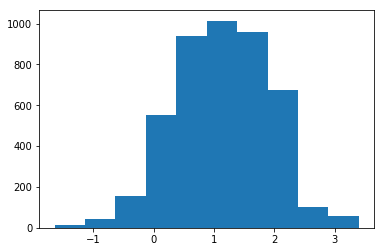

In [61]:
plt.hist([l for l in labels if l < 3.4])

In [341]:
def evaluate_peptide(peptide, model):
    sequence = peptide['sequence']
    cterm = peptide['has_cterminal_modification']
    return model.predict(row_to_vector(
        {'sequence': sequence, 'has_cterminal_modification': int(cterm)}
    ).reshape(-1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1))


def find_nearby_sequences(sequence, old_sequences=None, character_dict=CHARACTER_DICT):
    new_sequences = set()
    if old_sequences == None:
        old_sequences = set()

    for i in range(len(sequence)):
        for c1 in character_dict:
            for j in range(i + 1, len(sequence)):
                for c2 in character_dict:
                    new_sequence = sequence[:i] + c1 + sequence[i+1:j] + c2 + sequence[j+1:]
                    for cterm in (True, False):
                        ns_dict = {'sequence': new_sequence, 'has_cterminal_modification': cterm}
                        new_sequences.add(frozenset(ns_dict.items()))
    return old_sequences | new_sequences

def evaluate_peptides(peptides, model):
    return model.predict(
        np.array(
            [row_to_vector(dict(p)) for p in peptides]
        ).reshape(
            -1, MAX_SEQUENCE_LENGTH, len(character_to_index) + 1
        )
    )

In [116]:
random_sequence = generate_random_sequence(alphabet=list(CHARACTER_DICT))['sequence']
nearbys = find_nearby_sequences(random_sequence)

In [117]:
print(min(nearbys, key=lambda x: evaluate_peptide(dict(x), convmodel)))

frozenset([('has_cterminal_modification', False), ('sequence', u'CLHLQHKLYNLTELGSLYTANTCCPLMG')])


In [118]:
evaluate_peptide({'has_cterminal_modification': False, 'sequence': u'MKFSYTNAPPCCTMEHWFYMSCCQNNE'}, convmodel)

array([[3.495714]], dtype=float32)

In [119]:
evaluate_peptides(nearbys, convmodel)

array([[3.5059607],
       [3.495861 ],
       [3.502077 ],
       ...,
       [3.5038774],
       [3.5069056],
       [3.5053856]], dtype=float32)

In [343]:
def nearby_peptide_vectors(peptide_vector):
    nearby_vectors = []
    for i in range(len(peptide_vector)):
#         print peptide_vector[i]
        if np.sum(peptide_vector[i][:len(peptide_vector[i]-1)])>0.5:
            for j in range(len(peptide_vector[i]) - 1):  # - 1 because of amidation
                v = np.zeros(len(peptide_vector[i]))
                v[-1] = peptide_vector[0][-1]
                v[j] = 1
                new_vector = np.concatenate([
                    peptide_vector[:i],
                    v.reshape(-1, len(peptide_vector[i])),
                    peptide_vector[i+1:]
                ])
                if is_acceptable(vector_to_amp(new_vector)['sequence']):
                    nearby_vectors.append(new_vector)
                else:
                    print 'unacceptable! '+repr(vector_to_amp(new_vector)['sequence'])
#                     cterm_flipped = deepcopy(new_vector)
#                     reverse_cterm = (new_vector[0][-1] + 1) % 2
#                     for c in cterm_flipped:
#                         c[-1] = reverse_cterm
#                     nearby_vectors.append(cterm_flipped)
#         else:
#             print 'Nope!'+repr(i)
    return nearby_vectors

In [121]:
v = vectors[0]
(np.concatenate([v[:9], v[10:11], v[10:]]) == v).all()

False

In [122]:
vs = nearby_peptide_vectors(v)

In [193]:
from Bio import pairwise2
from Bio.SubsMat import MatrixInfo as matlist

In [344]:
def is_acceptable(sequence_with_padding):
    at_underscore=False
    for char in sequence_with_padding:
        if char == '_':
            at_underscore=True
        elif at_underscore:
            return False
    return True

In [364]:
def generate_sequence(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    for i in range(100):
        vs = nearby_peptide_vectors(v)
        ps = convmodel.predict(np.array(vs))
        best_i = min(range(len(ps)), key=lambda x: ps[x])
        v = vs[best_i]
        if vector_to_amp(v)['sequence']==last:
            break
        last=vector_to_amp(v)['sequence']
    return vector_to_amp(v), ps[best_i][0]

def generate_random_sequences(cdict=CHARACTER_DICT,min_seq_length=10):
    s = generate_random_sequence(cdict,length_of_sequence_min=min_seq_length)
    v = row_to_vector(s)
    last=''
    p=convmodel.predict(np.array([v]))
    return vector_to_amp(v), p[0][0]

In [350]:
nseqs=10
sequences=['']*nseqs
pred_log_mics=[0]*nseqs
for i in range(nseqs):
    seq,plm=generate_sequence()
    sequences[i]=seq
    pred_log_mics[i]=plm
print sequences
print pred_log_mics

[{'cterminal_amidation': False, 'sequence': u'CEMNIDQISFQGHAWTWAEASMSYQRFNLRR_______________'}, {'cterminal_amidation': False, 'sequence': u'CFLCLSKTEERQPPWWHTGL__________________________'}, {'cterminal_amidation': False, 'sequence': u'GGMLKVLNVYGRCTGRHTKI__________________________'}, {'cterminal_amidation': False, 'sequence': u'RKWFKYCITVWQ__________________________________'}, {'cterminal_amidation': False, 'sequence': u'TDWFVSILLNSNCQKHNTPLYGY_______________________'}, {'cterminal_amidation': False, 'sequence': u'STDRLLYSFGVRAKFRRTVYRQYIWA____________________'}, {'cterminal_amidation': False, 'sequence': u'GWWGTCTRGPQFTITLLH____________________________'}, {'cterminal_amidation': True, 'sequence': u'RKWRVKRIFW____________________________________'}, {'cterminal_amidation': False, 'sequence': u'IERKKWPIGKVCRNRYGRKIRR________________________'}, {'cterminal_amidation': False, 'sequence': u'NNWKTSSCARLYIRNTSYGIYIPL______________________'}]
[3.0303533, -0.5222174, -0.5406635, -0.018530548, 

In [365]:
nseqs=10
sequences=['']*nseqs
pred_log_mics=[0]*nseqs
for i in range(nseqs):
    seq,plm=generate_random_sequences()
    sequences[i]=seq
    pred_log_mics[i]=plm
print sequences
print pred_log_mics

[{'cterminal_amidation': False, 'sequence': u'MTECDVHHQVHSNEPHFFPKRHRDMFCIS_________________'}, {'cterminal_amidation': False, 'sequence': u'DSGMHMTRKQIEFCVRCAAAN_________________________'}, {'cterminal_amidation': False, 'sequence': u'ICYHMYEVPMSVSDMIRHWFFGE_______________________'}, {'cterminal_amidation': False, 'sequence': u'NRCWCVQCEQHFNKYDVDTWRSPQNDNVDAVLRAFIE_________'}, {'cterminal_amidation': False, 'sequence': u'MSYTRRVLYH____________________________________'}, {'cterminal_amidation': True, 'sequence': u'GNSFHTYKNFLMVAV_______________________________'}, {'cterminal_amidation': False, 'sequence': u'VITLDSIKENTDVEDVQAAIVYKIFPGQGD________________'}, {'cterminal_amidation': True, 'sequence': u'KPFIHVPMCNM___________________________________'}, {'cterminal_amidation': True, 'sequence': u'DMIPWKWMGRIRLDTRMFCLVYRGE_____________________'}, {'cterminal_amidation': True, 'sequence': u'ANWMGPPAWQL___________________________________'}]
[3.4446352, 1.3010713, 3.4469535, 3.4841344, 1.490310

In [357]:
best_indices=np.argpartition(pred_log_mics,4)[:4]
print best_indices
for index in best_indices:
    seq=sequences[index]['sequence'][:sequences[index]['sequence'].find('_')]
    print seq
    print pred_log_mics[index]
    show_best_n_alignments(seq,all_sequences,1)
    print hmoment_analysis(seq)
    print '\n'

[5 9 8 4]
STDRLLYSFGVRAKFRRTVYRQYIWA
-0.7726675
-STDRLLYSFGVRA---KFRRTVYRQYIWA--
    |||||||||||||||||
KFFARLLAS--VRAAVKKFRKKPRLIGLSTLL
  Score=44

([0.12278864701782083, 0.20286915096955999, 0.3011538461538461], [20.600000000000023, 43.60000000000035, 75.49999999999999])


NNWKTSSCARLYIRNTSYGIYIPL
-0.69088924
------------NNWKTSSCARLYIRNTSYGIYIPL
              ||||||||||||||
SIITMTKEAKLPQSWKQIAC-RLY--NTC-------
  Score=39

([0.17389519071164913, 0.18354438021502917, 0.23750000000000013], [47.3000000000004, 48.40000000000042, 72.70000000000014])


IERKKWPIGKVCRNRYGRKIRR
-0.7141862
IERKKWPIGKVCRNRYGRKIRR
   ||||||||
KVVKQWPIGKVVKKVVKKVVK-
  Score=53

([0.3740757975896999, 0.32365788895088604, 0.18727272727272723], [74.60000000000004, 62.200000000000614, 43.40000000000035])


TDWFVSILLNSNCQKHNTPLYGY
-0.633139
TDWFVSILLN--SNCQKHNTPLYGY--
   |||||||||||
---FLSTLLNVASNVVPTLICKITKKC
  Score=37

([0.06411761540563234, 0.0539340076091686, 0.12608695652173915], [12.79999999999997, 8.299999999999

In [210]:
def show_best_n_alignments(test_sequence,sequence_db,nalign,score_matrix=matlist.pam30,gap_open_penalty=-9,gap_extension_penalty=-1):
#     blosum62 is another option. Identity matrix is another. I think they're about the same.
    alignment_scores=[0]*len(sequence_db)
    for i in range(len(all_sequences)):
        sequence=all_sequences[i]
        alignment_scores[i]=pairwise2.align.localds(test_sequence,sequence,score_matrix,gap_open_penalty,gap_extension_penalty,score_only=True)
    argm = np.argmax(alignment_scores)
#     alignments=pairwise2.align.localds(test_sequence,all_sequences[argm],score_matrix,gap_open_penalty,gap_extension_penalty)
    indices=np.argpartition(alignment_scores,-1*nalign)[(-1*nalign):]
    for index in indices:
        alignments=pairwise2.align.localds(test_sequence,all_sequences[index],score_matrix,gap_open_penalty,gap_extension_penalty)
        print(pairwise2.format_alignment(*alignments[0]))

In [212]:
all_sequences=[sequence for sequence in ecoli_df.sequence]
show_best_n_alignments('GRRWKLMKHVTETPNPR',all_sequences,3)

GRRWKLMKHVTETPNPR
||||||||||
GKWWSLLKHILK-----
  Score=39

GRRWKLMKHVTETPNPR-----
   |||||||
--KWKLKKHIGIGKHFLSAKKF
  Score=43

GRRW-KLMKHVTETPNPR
 |||||||
RRRWWKLMM---------
  Score=45



In [237]:
def hmoment_analysis(test_sequence,angles=[100,140,180]):
    hmoments=[0]*len(angles)
    percentiles=[0]*len(angles)
    for k in range(len(angles)):
        test_angle=angles[k]
        hmoments[k] = hydrophobic_moment(test_sequence,angle=test_angle)
        other_h_moments=[0]*1000
        shuffled=range(len(test_sequence))
        perGreater=0
        for i in range(1000):
            np.random.shuffle(shuffled)
            shuffled_seq=[test_sequence[j] for j in shuffled]
            other_h_moments[i]=hydrophobic_moment(shuffled_seq,angle=test_angle)
            if other_h_moments[i]<hydrophobic_moment(test_sequence,angle=test_angle):
                perGreater+=.1
        percentiles[k]=perGreater
    return hmoments,percentiles

In [239]:
print hmoment_analysis(u'YLFGLRVGKCWERNKALIAGTVLRISFH')

([0.28744000139810794, 0.23115044867895798, 0.19357142857142856], [76.69999999999992, 59.70000000000058, 59.20000000000057])


In [276]:
v[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.])